http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/

https://www.kaggle.com/mayurjain/ml-bank-marketing-solution/code

In [1]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("bank-dataset.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Análisis exploratorio de los datos

In [3]:
df.shape

(45211, 17)

### Variables binarias

In [4]:
binary_col_list = ['y', 'loan', 'housing', 'default']
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
no,39922,37967,20081,44396
yes,5289,7244,25130,815


In [5]:
df[binary_col_list] = df[binary_col_list].apply(lambda x: x.map(dict(yes=1, no=0)))
df[binary_col_list].apply(lambda x: x.value_counts())

,y,loan,housing,default
0,39922,37967,20081,44396
1,5289,7244,25130,815


In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [7]:
df.dtypes

age           int64
job          object
marital      object
education    object
default       int64
balance       int64
housing       int64
loan          int64
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [8]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


### Variable job

In [9]:
df.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [10]:
df['job'] = df.job.replace(['management', 'admin.'], 'administration')
df['job'] = df.job.replace(['services', 'housemaid'], 'services')
df['job'] = df.job.replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

In [11]:
df.job.value_counts()

administration    14629
blue-collar        9732
technician         7597
services           5394
other              4793
self-employed      1579
entrepreneur       1487
Name: job, dtype: int64

### Variable marital

In [12]:
df.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

### Variable education

In [13]:
df.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

### Variable contact

In [14]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

### Variable month

In [15]:
df.month.value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

### Variable poutcome

In [16]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [17]:
df['poutcome'] = df.poutcome.replace(['unknown'], 'other')

In [18]:
df.poutcome.value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

### Variable **pdays**

In [19]:
df.loc[df.pdays == -1, 'pdays'].count() / len(df)

0.81736745482294137

El 81% de los registros de la variable **pdays** es -1, lo cual quiere decir que el cliente nunca fue contactado anteriormente. Por lo tanto, la variable **poutcome** tendrá el valor *unknown* un 81% de las veces, al igual que la variable **previous** con el valor 0.

In [20]:
print(df.loc[df.poutcome == 'unknown', 'poutcome'].count() / len(df))
print(df.loc[df.previous == 0, 'previous'].count() / len(df))

0.0
0.817367454823


### Variable duration

Pasamos los segundos a minutos

In [21]:
df['duration'] = df.duration / 60

### Valores nulos

In [22]:
null_data = df.isnull().mean()
null_data.sort_values(ascending=False)

y            0.0
loan         0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
contact      0.0
poutcome     0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
age          0.0
dtype: float64

### Correlación entre variables

In [23]:
corr = df.corr()
corr

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,-0.010021,0.016822,-0.029979,-0.018329,-0.022419
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.139173
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022754,-0.011043,-0.068185
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236


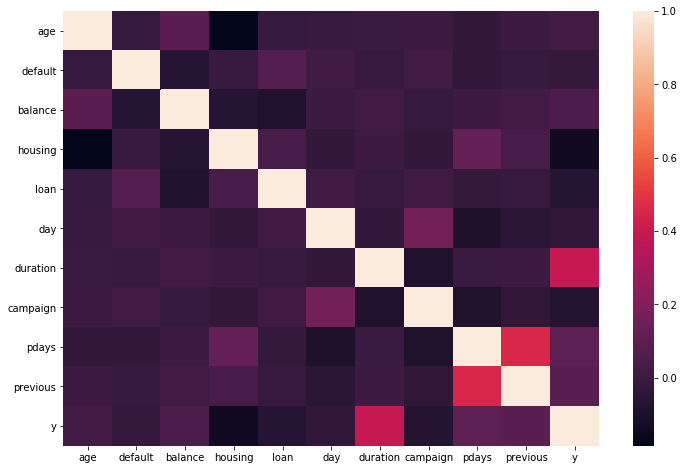

In [24]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Análisis de las variables continuas

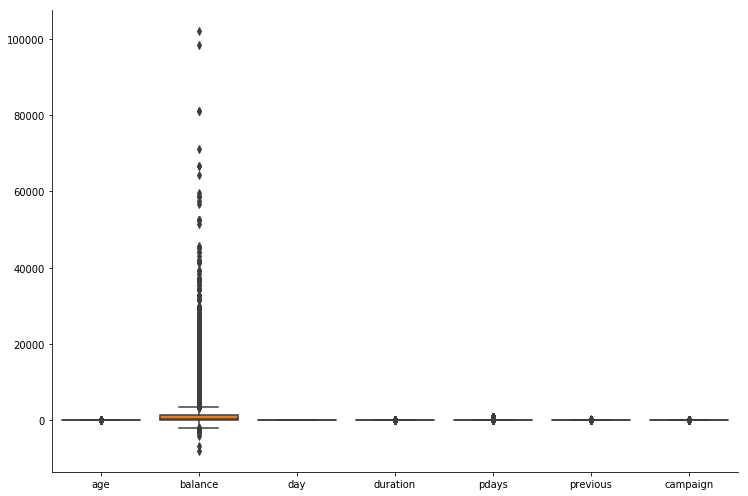

In [25]:
continuous_feature_list = ['age', 'balance', 'day', 'duration', 'pdays', 'previous', 'campaign']

sns.factorplot(kind='box',
               data=df[continuous_feature_list],
               size=7,
               aspect=1.5,
               legend_out=False)

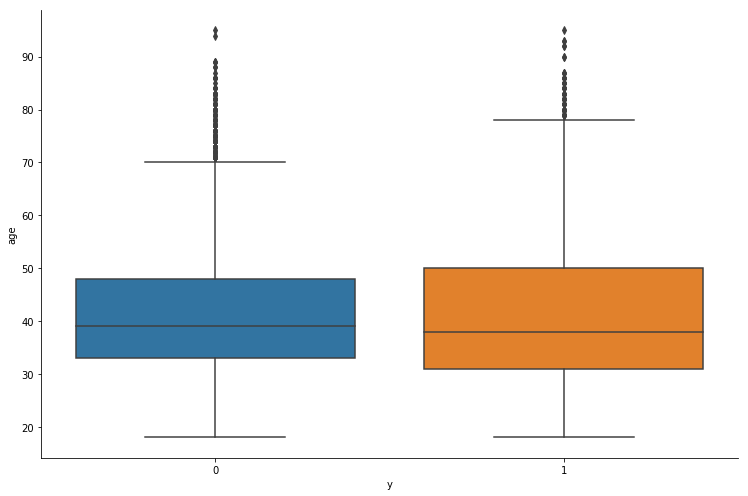

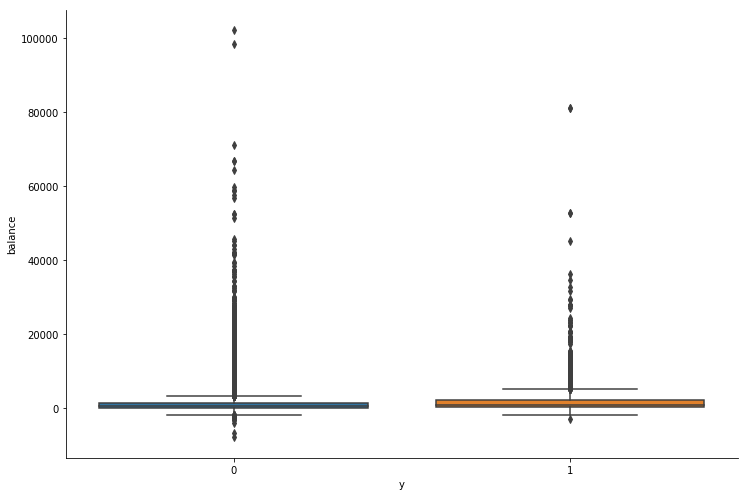

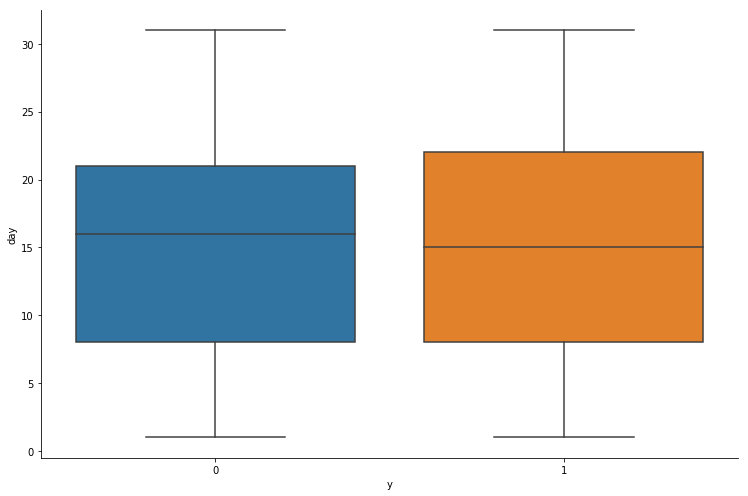

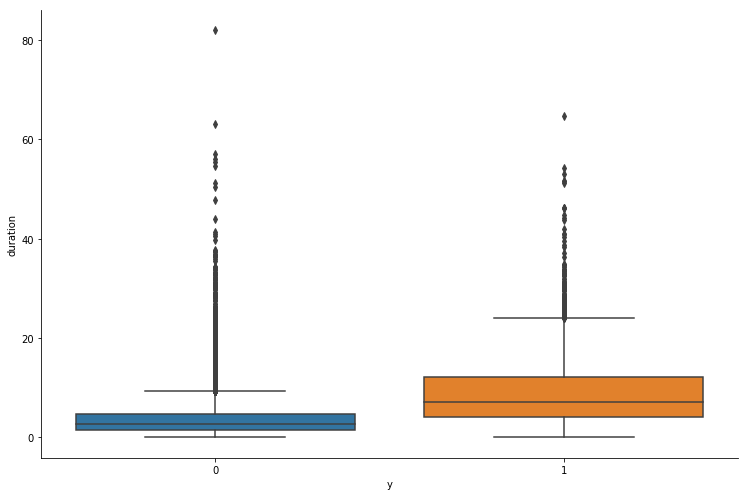

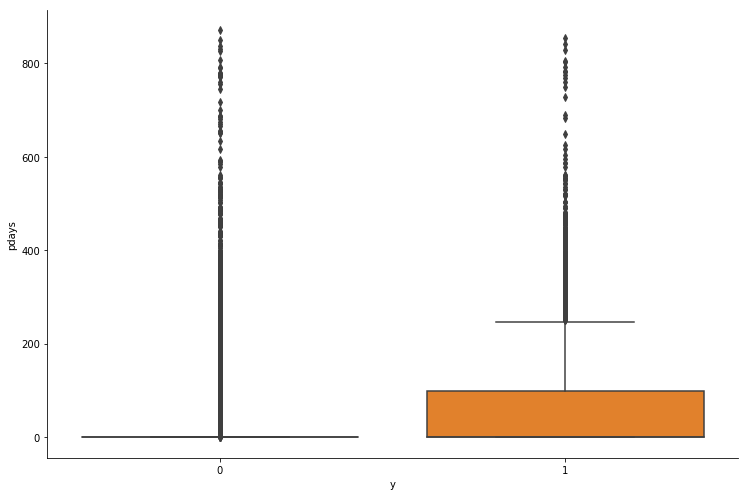

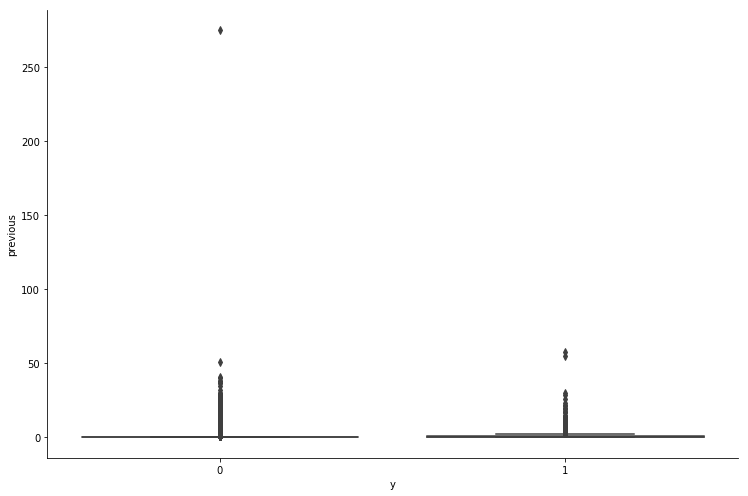

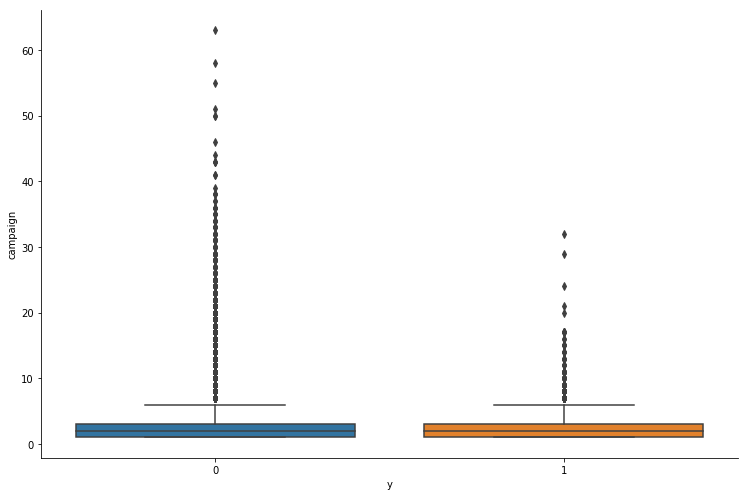

In [26]:
for i in continuous_feature_list:
    sns.factorplot(kind='box',
                   x='y',
                   y=i,
                   data=df,
                   size=7,
                   aspect=1.5,
                   legend_out=False)

### Outliers

In [27]:
len(df[df.previous > 50])

4

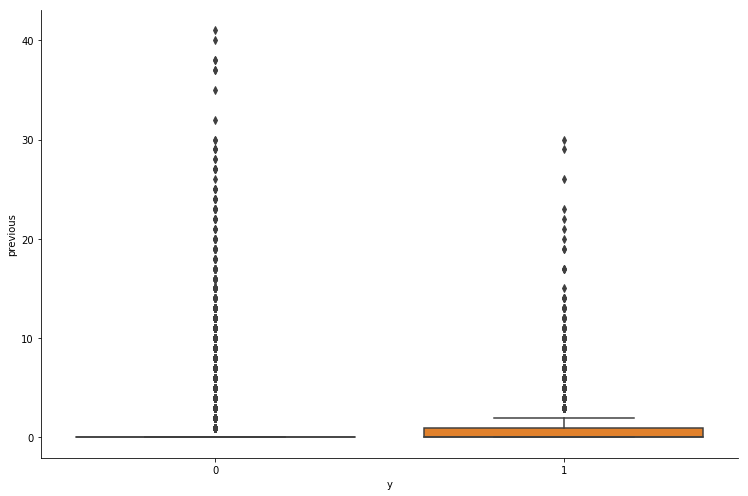

In [28]:
df = df[df.previous < 50]

sns.factorplot(kind='box',
               x='y',
               y='previous',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

In [29]:
len(df[df.duration > 60])

3

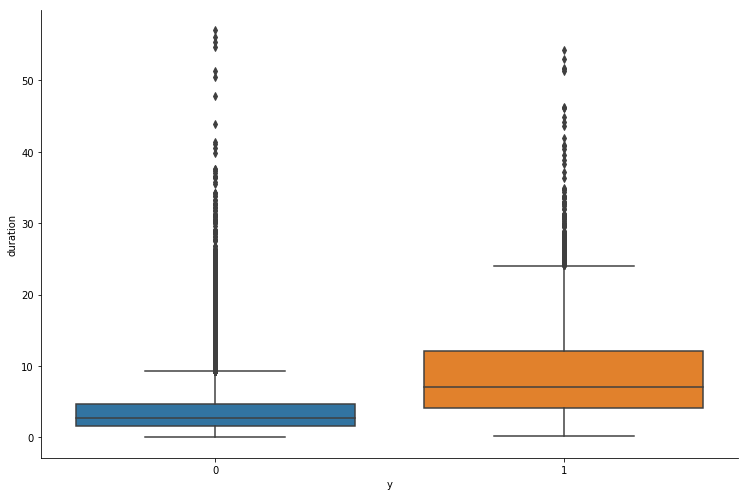

In [30]:
df = df[df.duration < 60]

sns.factorplot(kind='box',
               x='y',
               y='duration',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

In [31]:
len(df[df.balance > 60000])

8

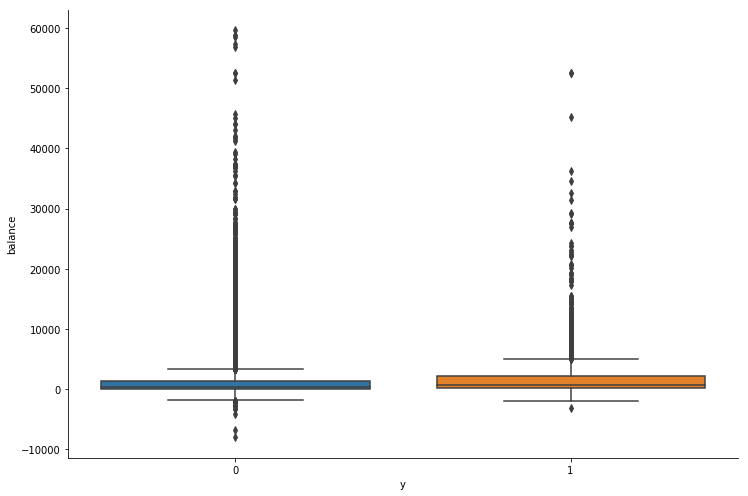

In [32]:
df = df[df.balance < 60000]

sns.factorplot(kind='box',
               x='y',
               y='balance',
               data=df,
               size=7,
               aspect=1.5,
               legend_out=False)

### Histogramas

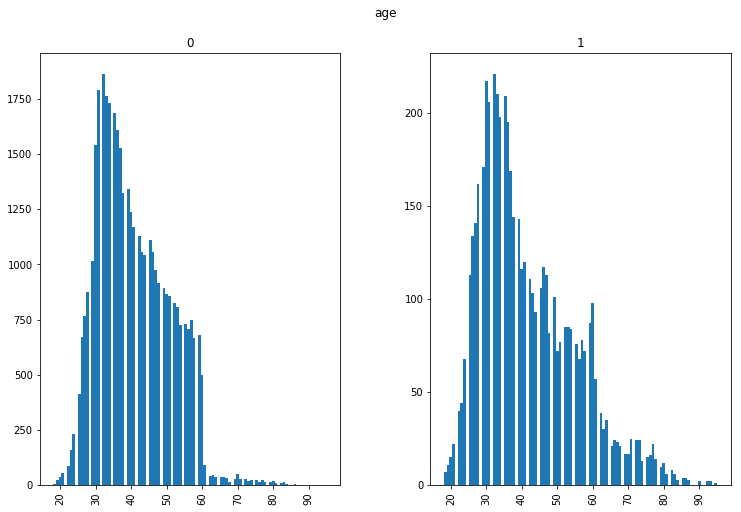

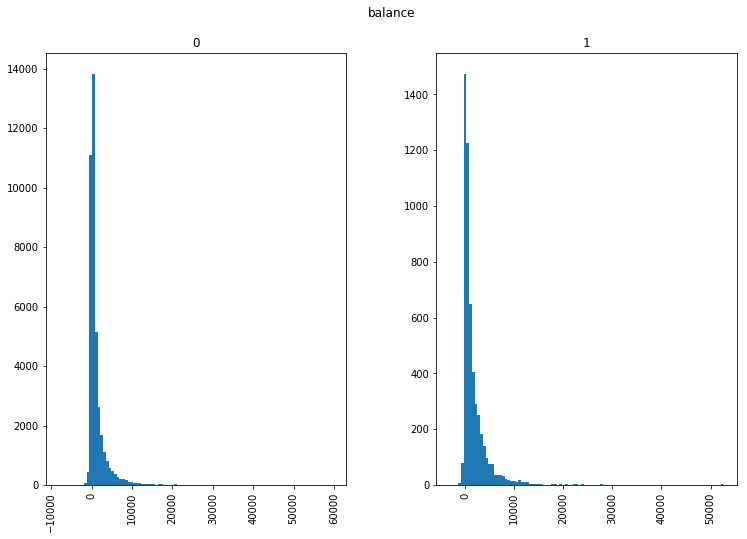

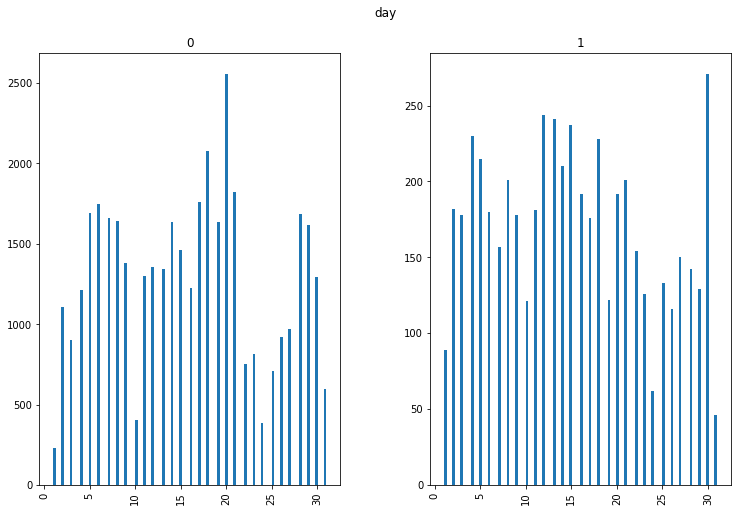

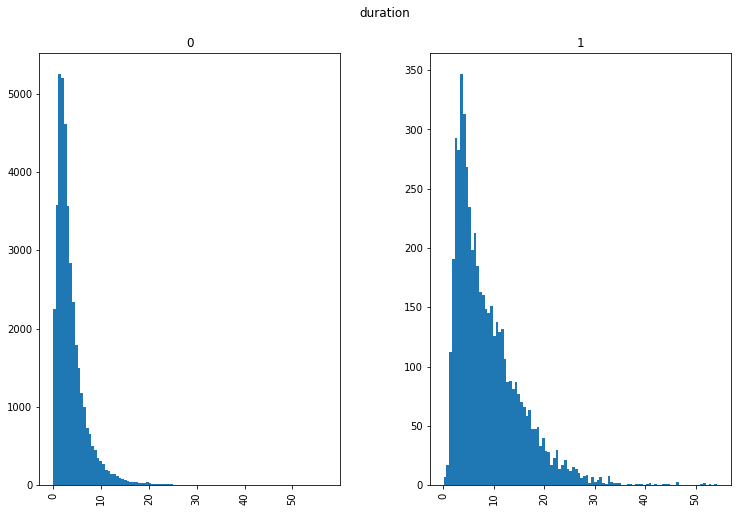

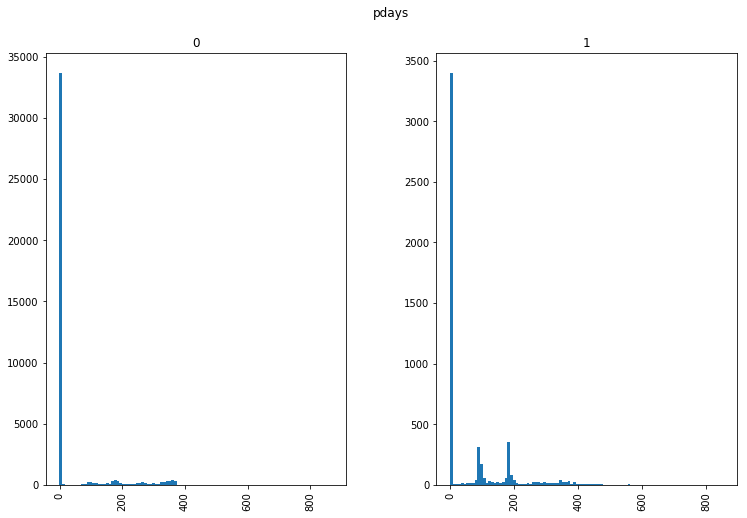

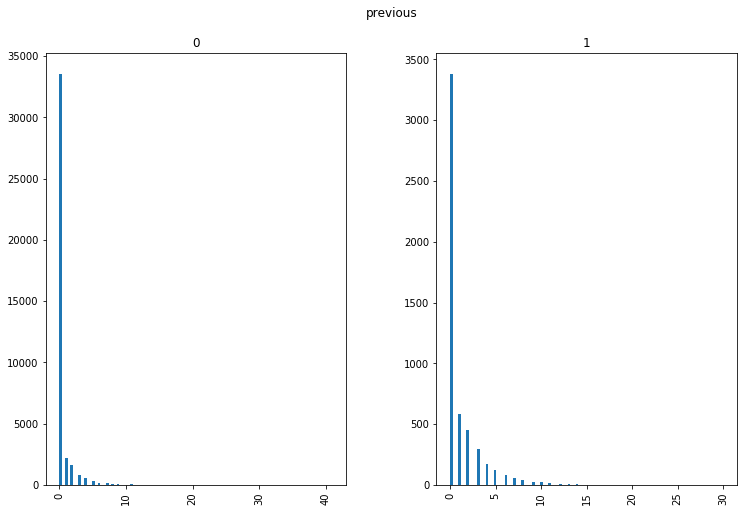

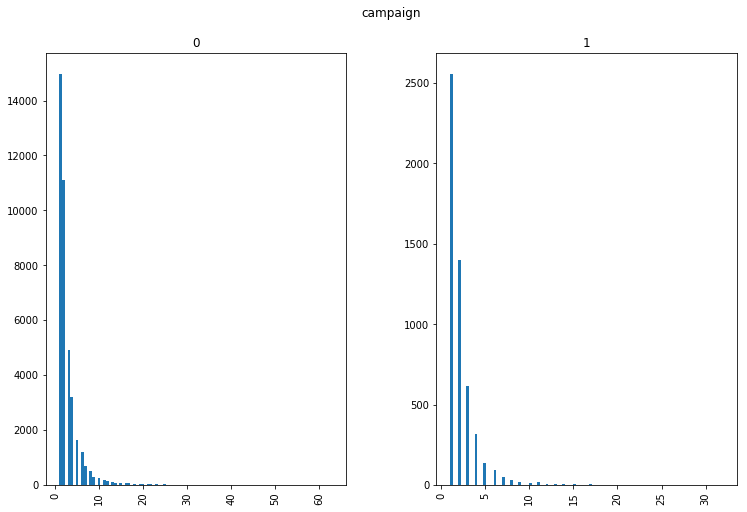

In [33]:
for i in continuous_feature_list:
    df.hist(column=i, by='y', bins=100)
    plt.suptitle(i)

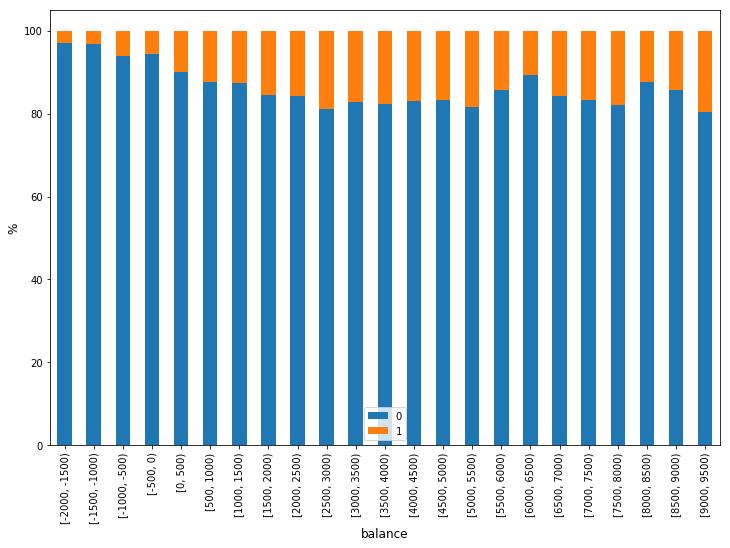

In [34]:
ranges =  [i for i in range(-2000, 10000, 500)]

temp = df[['balance', 'y']].groupby([pd.cut(df.balance, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("balance", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

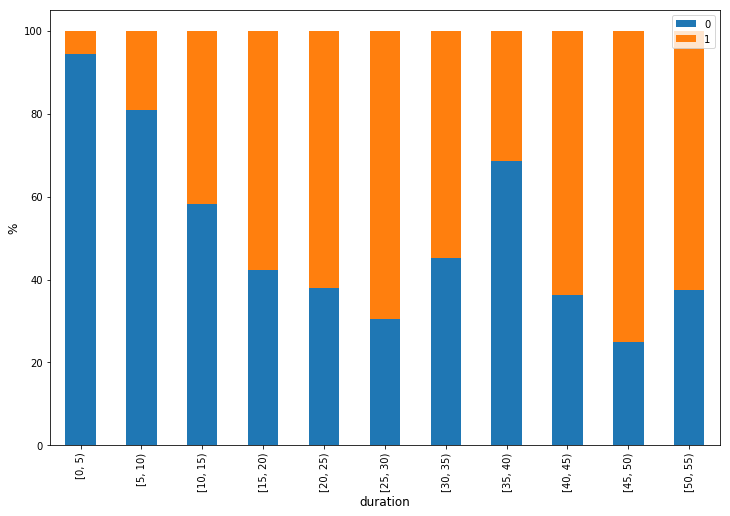

In [35]:
ranges =  [i for i in range(int(min(df.duration)), int(max(df.duration)), 5)]

temp = df[['duration', 'y']].groupby([pd.cut(df.duration, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("duration", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

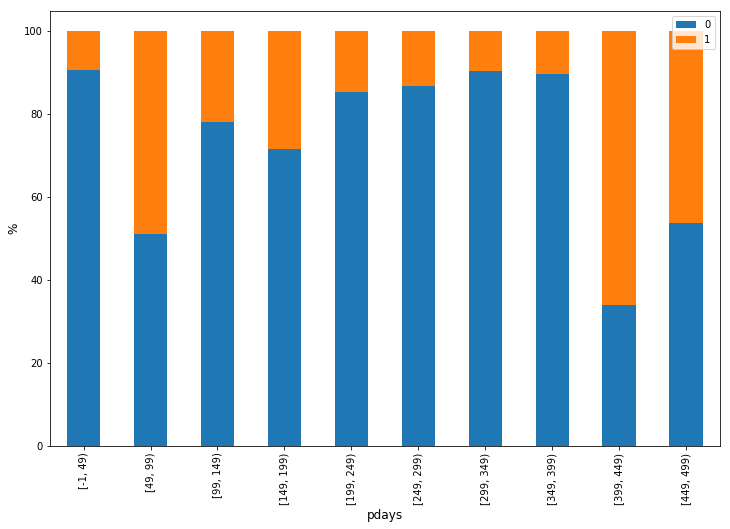

In [36]:
ranges =  [i for i in range(min(df.pdays), 500, 50)]

temp = df[['pdays', 'y']].groupby([pd.cut(df.pdays, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("pdays", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

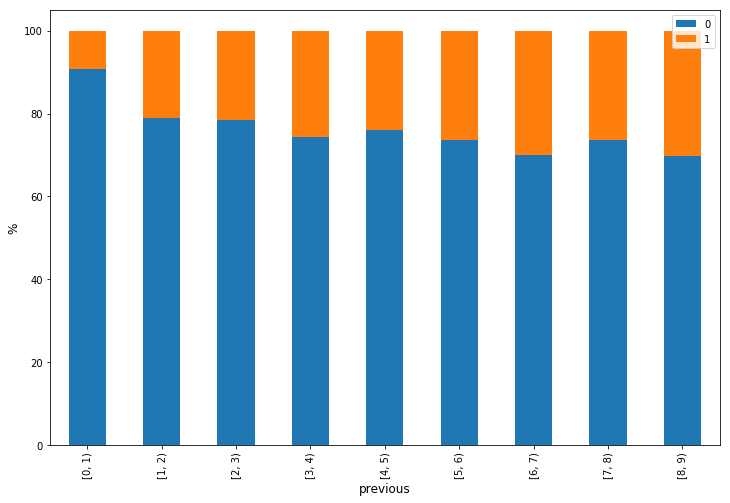

In [37]:
ranges =  [i for i in range(min(df.previous), 10, 1)]

temp = df[['previous', 'y']].groupby([pd.cut(df.previous, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("previous", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

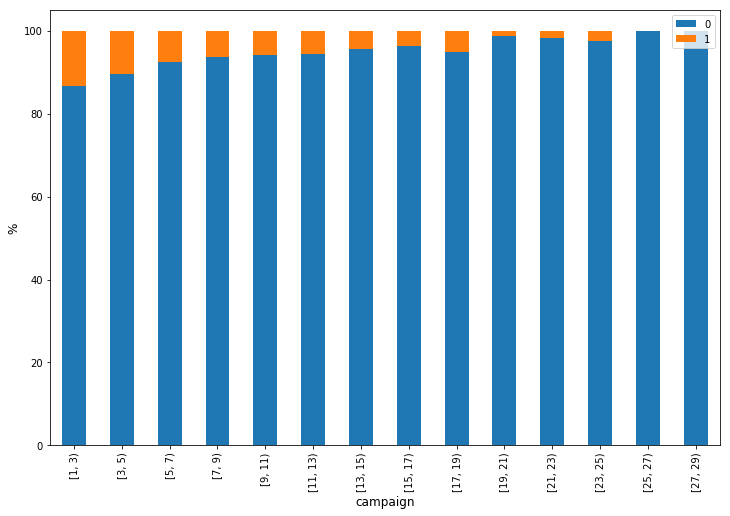

In [38]:
ranges =  [i for i in range(min(df.campaign), 30, 2)]

temp = df[['campaign', 'y']].groupby([pd.cut(df.campaign, ranges, right=False), 'y']).count()
temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

ax = temp.plot(kind='bar', legend=True, stacked=True)
ax.set_xlabel("campaign", fontsize=12)
ax.set_ylabel("%", fontsize=12)
ax.legend(["0", "1"])

## Análisis de variables descriptivas

Text(81.125,0.5,'Number of elements')

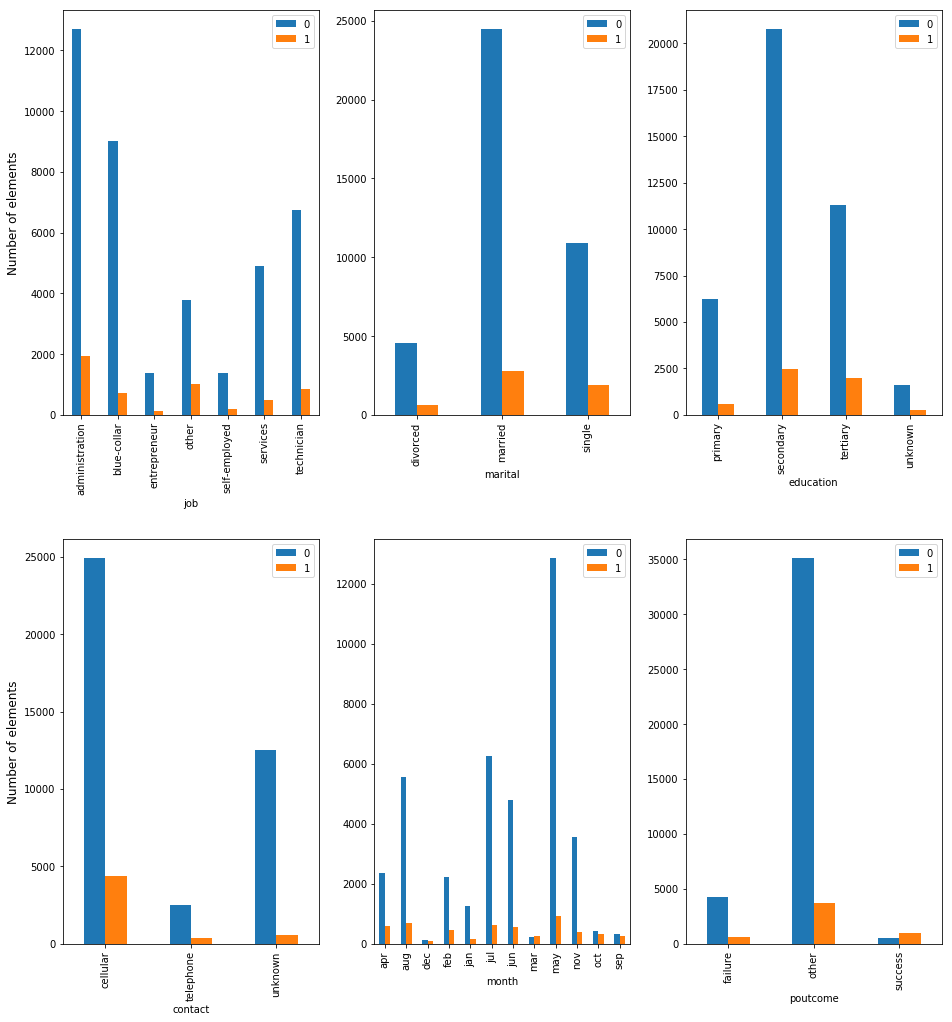

In [39]:
descriptive_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

fig, axis = plt.subplots(ncols=3, nrows=2)
plt.tight_layout(h_pad=5, w_pad=2)

for i, ax in enumerate(fig.axes):
    temp = df[[descriptive_features[i], 'y']].groupby([descriptive_features[i], 'y']).size().unstack()

    temp.plot(kind='bar', legend=True, ax=ax, figsize=(13, 14))
    ax.legend(["0", "1"])
    
axis[0][0].set_ylabel("Number of elements", fontsize=12)
axis[1][0].set_ylabel("Number of elements", fontsize=12)

Text(81.125,0.5,'Number of elements')

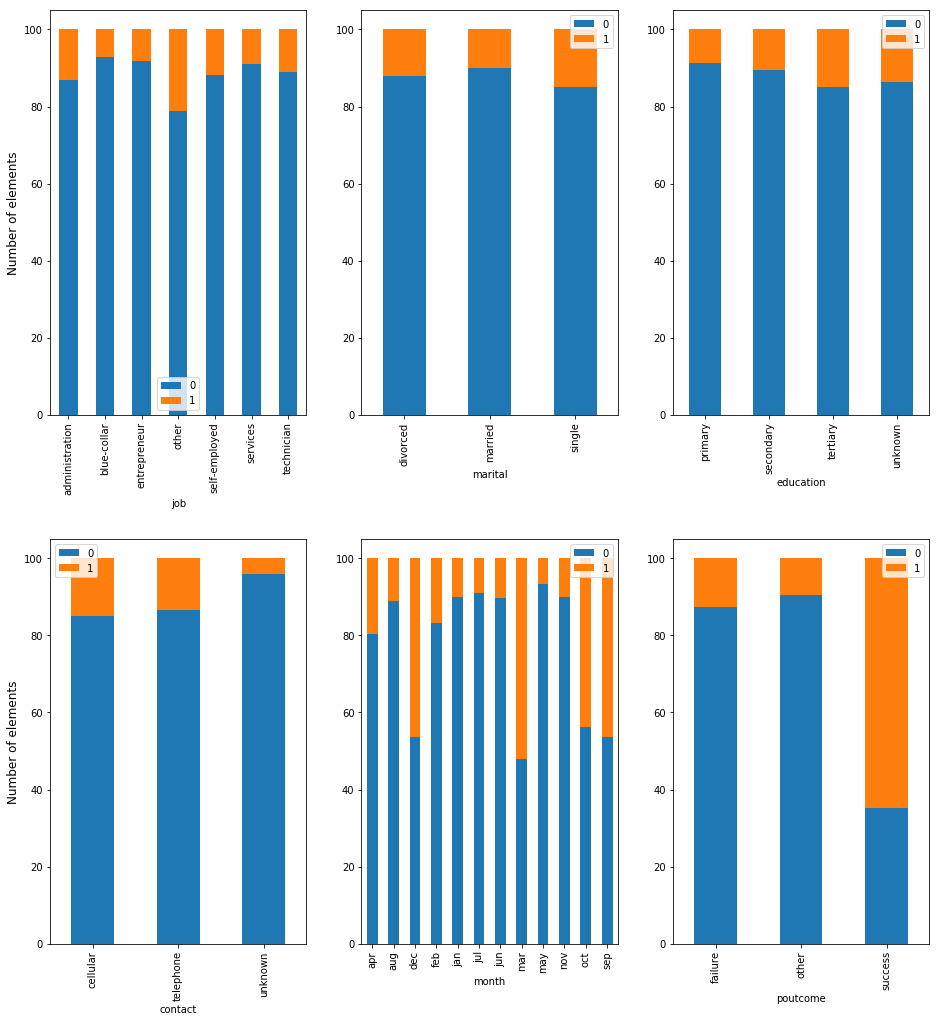

In [40]:
descriptive_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

fig, axis = plt.subplots(ncols=3, nrows=2)
plt.tight_layout(h_pad=5, w_pad=2)

for i, ax in enumerate(fig.axes):
    temp = df[[descriptive_features[i], 'y']].groupby([descriptive_features[i], 'y']).size()
    temp = temp.groupby(level=0).apply(lambda x: x * 100 / x.sum()).unstack()

    temp.plot(kind='bar', legend=True, ax=ax, figsize=(13, 14), stacked=True)
    ax.legend(["0", "1"])
    
axis[0][0].set_ylabel("Number of elements", fontsize=12)
axis[1][0].set_ylabel("Number of elements", fontsize=12)

## Chi Square and Feature Importance Test

In [41]:
from sklearn.feature_selection import SelectKBest, chi2

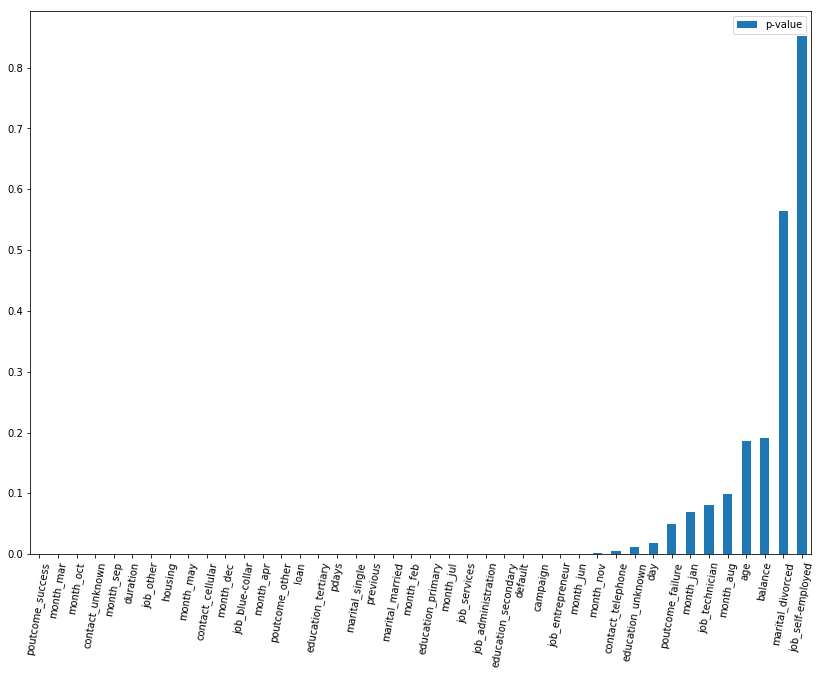

In [42]:
X = df.loc[:, df.columns != 'y']
Y = df.y

X_dummies = pd.get_dummies(X)
X_dummies_min_max = MinMaxScaler().fit_transform(X_dummies)

k_best_features = SelectKBest(chi2, k=10).fit(X_dummies_min_max, Y)

feat = pd.DataFrame(index=X_dummies.keys(), data=k_best_features.pvalues_, columns=['p-value'])
feat = feat.sort_values(by='p-value', ascending=True)

feat.plot(kind='bar', rot=80, figsize=(14, 10))

In [43]:
from sklearn.ensemble import RandomForestClassifier

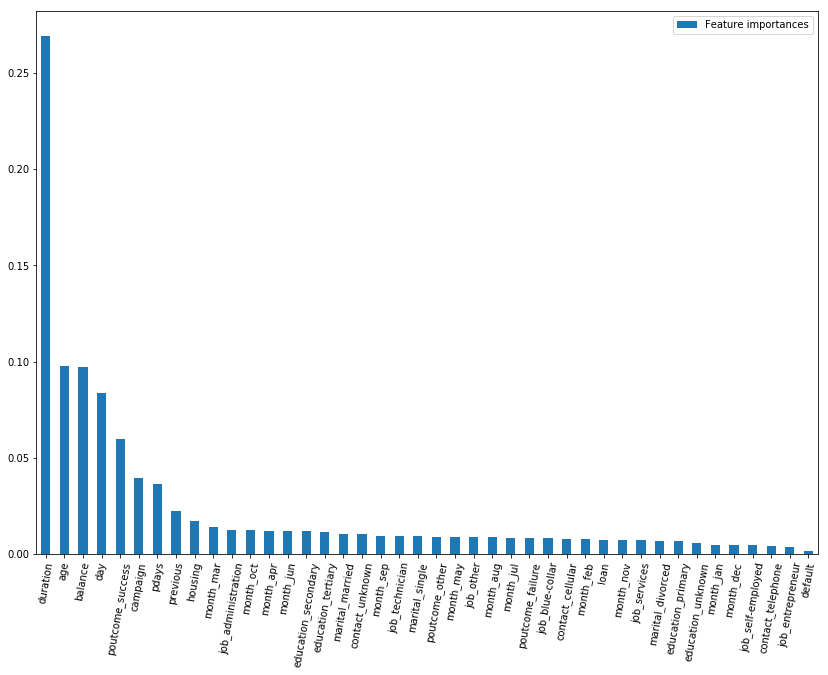

In [44]:
X = df.loc[:, df.columns != 'y']
Y = df.y

# Get dummies
X_dummies = pd.get_dummies(X)

# Scale between 0 to 1
X_dummies_min_max = MinMaxScaler().fit_transform(X_dummies)

# Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_dummies_min_max, Y)

feat = pd.DataFrame(index=X_dummies.keys(), data=model.feature_importances_, columns=['Feature importances'])
feat = feat.sort_values(by='Feature importances', ascending=False)

feat.plot(kind='bar', rot=80, figsize=(14, 10))

# Selección del conjunto de datos final

Borrar variables **job**, **default**, **marital**, **contact**

In [45]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [46]:
df_final = df[df.columns.difference(['job', 'marital', 'default', 'contact'])]

In [47]:
df_dummies = pd.get_dummies(df_final)
df_dummies.shape

(45196, 29)

In [48]:
df_dummies.head()

,age,balance,campaign,day,duration,housing,loan,pdays,previous,y,education_primary,education_secondary,education_tertiary,education_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,58,2143,1,5,4.350000,1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,44,29,1,5,2.516667,1,0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,33,2,1,5,1.266667,1,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,47,1506,1,5,1.533333,1,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,33,1,1,5,3.300000,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# Separación de datos de entrenamiento y prueba

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
df_X = df_dummies.loc[:, df_dummies.columns != 'y']
df_y = df_dummies.y

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.3, 
                                                    random_state = 1234)

In [51]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (31637, 28)
X_test:  (13559, 28)
y_train: (31637,)
y_test:  (13559,)


# K-Nearest Neighbors Classifier

In [361]:
from sklearn.neighbors import KNeighborsClassifier

In [380]:
scaler = MinMaxScaler()
knn_class = KNeighborsClassifier()

scaler_step = ('scaler', scaler)
knn_class_step = ('knn', knn_class)
steps = [scaler_step, knn_class_step]
pipe = Pipeline(steps)

params = {'knn__n_neighbors': range(12, 20),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2]} # p = 1 -> manhattan_distance (L1), p = 2 -> euclidean_distance (L2)

kfold = StratifiedKFold(n_splits = 10)

gs_knn_class = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1, verbose=3)
gs_knn_class.fit(X_train, y_train)

y_pred_gs_knn_class = gs_knn_class.predict(X_test)
y_pred_gs_knn_class_proba = gs_knn_class.predict_proba(X_test)

print("Best params: ", gs_knn_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_knn_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_knn_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_knn_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_gs_knn_class))

Best params:  {'knn__p': 2, 'knn__weights': 'distance', 'knn__n_neighbors': 17}


ROC Curve: 0.88


Confusion matrix: 
 [[  496  1147]
 [  284 11632]]


Accuracy: 0.894461243455
Precision: 0.635897435897
Recall: 0.301886792453
F1: 0.409409822534


# Regresión logística

In [54]:
from sklearn.linear_model import LogisticRegression

In [59]:
scaler = MinMaxScaler()
class_LR = LogisticRegression()

scaler_step = ('scaler', scaler)
class_LR_step = ('class_LR', class_LR)
steps = [scaler_step, class_LR_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_LR = pipe.predict(X_test)
y_pred_LR_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_LR_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_LR, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_LR))

ROC Curve: 0.90


Confusion matrix: 
 [[  541  1102]
 [  286 11630]]


Accuracy: 0.897632568774


Classification report: 
              precision    recall  f1-score   support

          0       0.91      0.98      0.94     11916
          1       0.65      0.33      0.44      1643

avg / total       0.88      0.90      0.88     13559



Log loss: 0.25446851365


# Árbol de decisión

In [61]:
from sklearn.tree import DecisionTreeClassifier

### 6.1 Árbol de decisión básico <a class="anchor" id="arbol-decision-basico"></a>

Creamos un modelo con un árbol de decisión sin modificar ningún parámetro:

In [65]:
scaler = MinMaxScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)
steps = [scaler_step, class_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

y_pred_class_DT = pipe.predict(X_test)
y_pred_class_DT_proba = pipe.predict_proba(X_test)

print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_class_DT))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_class_DT))

ROC Curve: 0.70


Confusion matrix: 
 [[  781   862]
 [  895 11021]]


Accuracy: 0.870418172432


Classification report: 
              precision    recall  f1-score   support

          0       0.93      0.92      0.93     11916
          1       0.47      0.48      0.47      1643

avg / total       0.87      0.87      0.87     13559



### 6.2 Árbol de decisión mediante GridSearchCV <a class="anchor" id="arbol-decision-gs"></a>

Para ver si mejora un modelo basado en árboles de decisión, utilizamos la función de **GridSearchCV** para modificar los parámetros.

In [401]:
scaler = MinMaxScaler()
class_DT = DecisionTreeClassifier()

scaler_step = ('scaler', scaler)
class_DT_step = ('class_DT', class_DT)

steps = [scaler_step, class_DT_step]

pipe = Pipeline(steps)

params = {'class_DT__max_depth': range(5, 15),
          'class_DT__min_samples_split': range(5, 15),
          'class_DT__min_samples_leaf': range(5, 15),
          'class_DT__criterion': ['gini', 'entropy']}

kfold = StratifiedKFold(n_splits = 10)

gs_class_DT = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1, verbose=3)
gs_class_DT.fit(X_train, y_train)

y_pred_gs_class_DT = gs_class_DT.predict(X_test)
y_pred_gs_class_DT_proba = gs_class_DT.predict_proba(X_test)

print("Best params: ", gs_class_DT.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_gs_class_DT_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_gs_class_DT, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_gs_class_DT))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_gs_class_DT))

Fitting 5 folds for each of 2016 candidates, totalling 10080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 10080 out of 10080 | elapsed:  3.8min finished


Best params:  {'class_DT__min_samples_split': 12, 'class_DT__criterion': 'entropy', 'class_DT__min_samples_leaf': 9, 'class_DT__max_depth': 7}


ROC Curve: 0.88


Confusion matrix: 
 [[  630  1013]
 [  390 11526]]


Accuracy: 0.896526292499
Precision: 0.617647058824
Recall: 0.383444917833
F1: 0.47315058205


Observamos que la métrica ROC Curve ha pasado de un 0.92 a un 0.95, usando una profundidad de 3, lo que quiere decir que usa pocas variables para crear el árbol.

### 6.3 Visualización de las variables más importantes <a class="anchor" id="arbol-decision-visualizacion"></a>

In [402]:
class_DT = DecisionTreeClassifier(max_depth = gs_class_DT.best_params_['class_DT__max_depth'],
                                  min_samples_leaf = gs_class_DT.best_params_['class_DT__min_samples_leaf'],
                                  min_samples_split = gs_class_DT.best_params_['class_DT__min_samples_split'],
                                  criterion = gs_class_DT.best_params_['class_DT__criterion'])
class_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=12,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

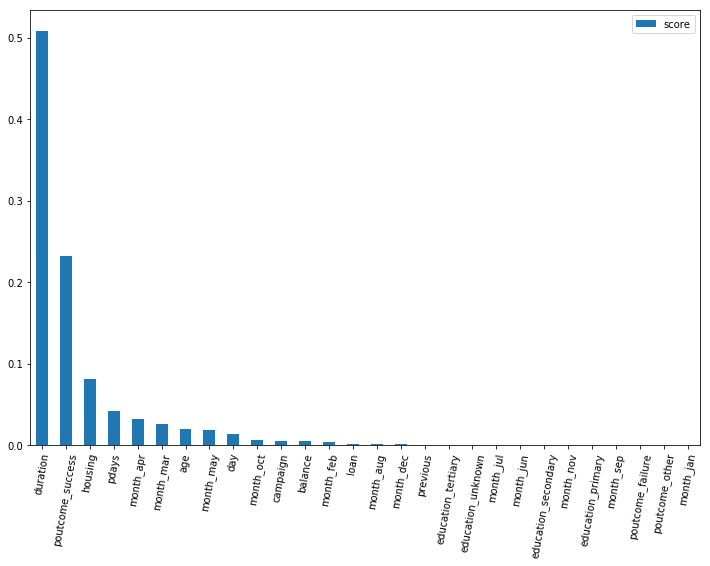

In [404]:
feat = pd.DataFrame(index=X_train.keys(), data=class_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat.plot(kind='bar', rot=80)

Como hemos dicho anteriormente, este modelo usa pocas variables para crear el árbol. En concreto usa 5, teniendo como la más importante **V14**.

### 6.4 Visualización del árbol final <a class="anchor" id="arbol-decision-final"></a>

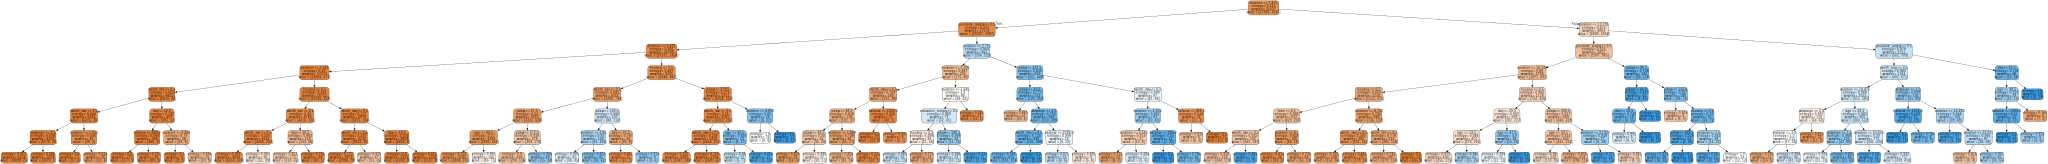

In [405]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(class_DT, 
                                  out_file=None, 
                                  feature_names=X_train.columns,
                                  filled=True,
                                  rounded=True)
graphviz.Source(tree_graph)

# Random Forest

In [406]:
from sklearn.ensemble import RandomForestClassifier

**Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza. Esto se hace de modo que cada vez que se hace una división en un árbol, se considera una selección aleatoria de m predictores elegidos como candidatos de división de todo el conjunto de p predictores.

Normalmente se usa $m = \sqrt{p}$, lo cual se refleja en el siguiente algoritmo mediante el parámetro *max_features = 'sqrt'*, aunque también se busca si con *max_features = 'auto'*, que es $m = p$ mejora el resultado. Además, con el parámetro n_estimators indicamos el número de árboles que se generan y con max_depth la profundidad de cada árbol. Estimamos la mejor combinación de estos parámetros mediante **GridSearchCV**.

In [408]:
scaler = MinMaxScaler()
rand_for_class = RandomForestClassifier()

scaler_step = ('scaler', scaler)
rand_for_class_step = ('rand_for_class', rand_for_class)
steps = [scaler_step, rand_for_class_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_class__n_estimators': range(25, 45, 2),
                    'rand_for_class__max_features': ['sqrt', 'auto'],
                    'rand_for_class__max_depth': range(12, 22)}

kfold = StratifiedKFold(n_splits = 10)

gs_rand_for_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=3)
gs_rand_for_class.fit(X_train, y_train)

y_pred_rand_for_class = gs_rand_for_class.predict(X_test)
y_pred_rand_for_class_proba = gs_rand_for_class.predict_proba(X_test)

print("Best params: ", gs_rand_for_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_rand_for_class[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_rand_for_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_rand_for_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_rand_for_class))

Fitting 3 folds for each of 442 candidates, totalling 1326 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1326 out of 1326 | elapsed:  3.8min finished


Best params:  {'rand_for_class__n_estimators': 37, 'rand_for_class__max_depth': 16, 'rand_for_class__max_features': 'sqrt'}


ROC Curve: 0.93


Confusion matrix: 
 [[  635  1008]
 [  338 11578]]


Accuracy: 0.900730142341
Precision: 0.652620760534
Recall: 0.386488131467
F1: 0.485474006116


### 7.1 Visualización de las variables más importantes <a class="anchor" id="random-forest-visualizacion"></a>

In [409]:
rand_for_class = RandomForestClassifier(
                    n_estimators = gs_rand_for_class.best_params_['rand_for_class__n_estimators'],
                    max_features = gs_rand_for_class.best_params_['rand_for_class__max_features'],
                    max_depth = gs_rand_for_class.best_params_['rand_for_class__max_depth'])
rand_for_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=37, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

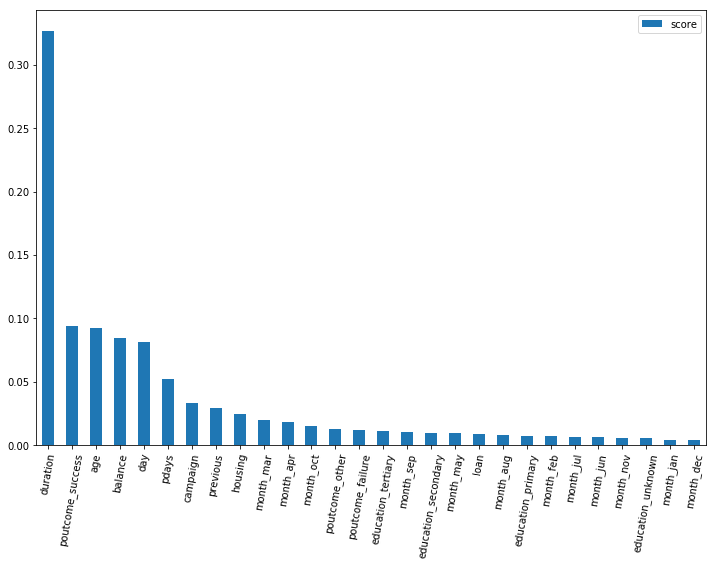

In [411]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_class.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat.plot(kind='bar', rot=80)

***

Observamos que los modelos de **Regresión Logística**, **Árbol de decisión** y **Random Forest** nos dan resultados parecidos. No obstante, como ya hemos dicho, **Random Forest** provee una mejora sobre los árboles de decisión para reducir la varianza, por lo que en los próximos modelos, en los que se ha usado **Resampling**, vamos a usar **Random Forest**.

# SVM

In [52]:
from sklearn.svm import SVC

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

The behavior of the model is very sensitive to the gamma parameter. If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.

When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.

![Validation accuracy](http://scikit-learn.org/stable/_images/sphx_glr_plot_rbf_parameters_002.png)

### Kernel linear

In [61]:
scaler = MinMaxScaler()
svc_lin_class = SVC(kernel='linear', 
                shrinking=True, 
                cache_size=2048, 
                random_state=1234)

scaler_step = ('scaler', scaler)
svc_lin_class_step = ('svc_lin_class', svc_lin_class)
steps = [scaler_step, svc_lin_class_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]

tuned_parameters = {'svc_lin_class__C': c}

kfold = StratifiedKFold(n_splits = 3)

gs_svc_lin_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=3)
gs_svc_lin_class.fit(X_train, y_train)

y_pred_svc_lin_class = gs_svc_lin_class.predict(X_test)

print("Best params: ", gs_svc_lin_class.best_params_)
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svc_lin_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_svc_lin_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_svc_lin_class))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.3min finished


[LibSVM]Best params:  {'svc_class__C': 0.01}


Confusion matrix: 
 [[  296  1347]
 [  157 11759]]


Accuracy: 0.889077365587
Precision: 0.653421633554
Recall: 0.180158247109
F1: 0.282442748092


### Kernel RBF

In [67]:
scaler = MinMaxScaler()
svc_rbf_class = SVC(kernel='rbf', 
                shrinking=True, 
                cache_size=2048, 
                random_state=1234)

scaler_step = ('scaler', scaler)
svc_rbf_class_step = ('svc_rbf_class', svc_rbf_class)
steps = [scaler_step, svc_rbf_class_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]

tuned_parameters = {'svc_rbf_class__C': c, 
                    'svc_rbf_class__gamma': gamma}

kfold = StratifiedKFold(n_splits = 3)

gs_svc_rbf_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=3)
gs_svc_rbf_class.fit(X_train, y_train)

y_pred_svc_rbf_class = gs_svc_rbf_class.predict(X_test)

print("Best params: ", gs_svc_rbf_class.best_params_)
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svc_rbf_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_svc_rbf_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_svc_rbf_class))

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  6.8min finished


Best params:  {'svc_rbf_class__C': 100, 'svc_rbf_class__gamma': 0.1}


Confusion matrix: 
 [[  513  1130]
 [  251 11665]]


Accuracy: 0.898148831035
Precision: 0.671465968586
Recall: 0.312233718807
F1: 0.426256751143


### Kernel poly

In [ ]:
scaler = MinMaxScaler()
svc_ps_class = SVC(kernel='poly'
                   shrinking=True, 
                   cache_size=2048, 
                   random_state=1234)

scaler_step = ('scaler', scaler)
svc_ps_class_step = ('svc_ps_class', svc_ps_class)
steps = [scaler_step, svc_ps_class_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]
degree = [2, 3]

tuned_parameters = {'svc_ps_class__C': c, 
                    'svc_ps_class__gamma': gamma,
                    'svc_ps_class__degree': degree}

kfold = StratifiedKFold(n_splits = 3)

gs_svc_ps_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=3)
gs_svc_ps_class.fit(X_train, y_train)

y_pred_svc_ps_class = gs_svc_ps_class.predict(X_test)

print("Best params: ", gs_svc_ps_class.best_params_)
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svc_ps_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_svc_ps_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_svc_ps_class))

Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.6min


# Redes neuronales

In [52]:
from sklearn.neural_network import MLPClassifier

Generamos varias combinaciones de número de neuronas en una, dos y tres capas.

In [78]:
import itertools

n_neurons = [1, 3, 5, 10]
hidden_layer_sizes = n_neurons

for two_layer in itertools.product(n_neurons, repeat=2):
    hidden_layer_sizes.append(two_layer)

n_neurons = [1, 3, 5]
for three_layer in itertools.product(n_neurons, repeat=3):
    hidden_layer_sizes.append(three_layer)
    
hidden_layer_sizes

[1,
 3,
 5,
 10,
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 10),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 10),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 10),
 (10, 1),
 (10, 3),
 (10, 5),
 (10, 10),
 (1, 1, 1),
 (1, 1, 3),
 (1, 1, 5),
 (1, 3, 1),
 (1, 3, 3),
 (1, 3, 5),
 (1, 5, 1),
 (1, 5, 3),
 (1, 5, 5),
 (3, 1, 1),
 (3, 1, 3),
 (3, 1, 5),
 (3, 3, 1),
 (3, 3, 3),
 (3, 3, 5),
 (3, 5, 1),
 (3, 5, 3),
 (3, 5, 5),
 (5, 1, 1),
 (5, 1, 3),
 (5, 1, 5),
 (5, 3, 1),
 (5, 3, 3),
 (5, 3, 5),
 (5, 5, 1),
 (5, 5, 3),
 (5, 5, 5)]

In [83]:
scaler = MinMaxScaler()
mlp_class = MLPClassifier(solver='adam',
                          max_iter=600,
                          random_state=1234)

scaler_step = ('scaler', scaler)
mlp_class_step = ('mlp_class', mlp_class)
steps = [scaler_step, mlp_class_step]
pipe = Pipeline(steps)

activation = ['logistic', 'relu']
alpha = [0.00001, 0.0001, 0.001]
learning_rate_init = [0.0001, 0.001, 0.01]

tuned_parameters = {'mlp_class__activation': activation, 
                    'mlp_class__alpha': alpha,
                    'mlp_class__learning_rate_init': learning_rate_init, 
                    'mlp_class__hidden_layer_sizes': hidden_layer_sizes}

kfold = StratifiedKFold(n_splits = 3)

gs_mlp_class = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=1)
gs_mlp_class.fit(X_train, y_train)

y_pred_mlp_class = gs_mlp_class.predict(X_test)
y_pred_mlp_class_proba = gs_mlp_class.predict_proba(X_test)

print("Best params: ", gs_mlp_class.best_params_)
print('\n')
print("ROC Curve: %.2f" % roc_auc_score(y_true=y_test, y_score=y_pred_mlp_class_proba[:, 1]))
print('\n')
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_mlp_class, labels=[1, 0]))
print('\n')
print("Accuracy:", accuracy_score(y_test, y_pred_mlp_class))
print('\n')
print("Classification report: \n", classification_report(y_test, y_pred_mlp_class))

Fitting 3 folds for each of 846 candidates, totalling 2538 fits


/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.war

KeyboardInterrupt: 